# good model, saved and done.

# units = 64

In [1]:
import numpy as np
import pandas as pd 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow import keras
#from tensorflow.keras.utils import to_categorical ## specific  one I wanna use
from tensorflow.keras import utils
#from tensorflow.keras.layers import Input, Dense, Dropout  # Specific ones I wanna use, can just import whole module
from tensorflow.keras import layers 
from tensorflow.keras.models import Model
import h5py
#import tables
import matplotlib.pyplot as plt
#import tensorflow as tf
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_curve
from sklearn.utils.class_weight import compute_class_weight


In [2]:
import tensorflow as tf
gpu_available = tf.test.is_gpu_available()
gpu_available

True

In [3]:
x=1
y=3
x+y

4

In [4]:
# Load padded data
with h5py.File('padded_arr_3d-Copy1.h5', 'r') as f:
    padded_arr_3d = f['array'][:]

with h5py.File('4_event_types_labels-Copy1.h5', 'r') as f:
    df_labels = f['array'][:]
    
with h5py.File('4_event_types_weights-Copy1.h5', 'r') as f:
    df_weights = f['array'][:]


In [5]:
padded_arr_3d.shape

(881096, 16, 23)

In [6]:
padded_arr_3d[800000,:,1]

array([ 2.0644531 ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.38549805,  0.        , 14.75      ,
        0.        ], dtype=float32)

In [7]:
X = padded_arr_3d
y = df_labels

print(X.shape)

# Break off validation set from training data
X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.8, test_size=0.2,
                                                      random_state=99)

input_shape = X_train.shape[2]
print('There are', input_shape, 'variables in this model')

(881096, 16, 23)
There are 23 variables in this model


In [2]:
# Define a RNN

#input_shape = (None, X_train.shape[2]) # shape of input sequence
#input_shape = (16, X_train.shape[2]) # shape of input sequence#
input_shape = (16,23)

model = keras.Sequential([
    layers.Masking(mask_value=0.0, input_shape=input_shape),
    layers.LSTM(units=64, return_sequences=True),
    layers.BatchNormalization(),
    layers.Dropout(rate=0.1), 
    layers.LSTM(units=64),
    layers.BatchNormalization(),
    layers.Dropout(rate=0.1),
    layers.Dense(units=1, activation='sigmoid'),
])

from tensorflow.keras.optimizers import Adam

lr = 0.0005 # specify learning rate
optimizer = Adam(learning_rate=lr)
#model.compile(optimizer=optimizer, loss='categorical_crossentropy')



model.compile(
    optimizer=optimizer,
    loss='binary_crossentropy',
    metrics=['binary_accuracy'],
)

model.summary()
#model.get_config()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
masking (Masking)            (None, 16, 23)            0         
_________________________________________________________________
lstm (LSTM)                  (None, 16, 64)            22528     
_________________________________________________________________
batch_normalization (BatchNo (None, 16, 64)            256       
_________________________________________________________________
dropout (Dropout)            (None, 16, 64)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                33024     
_________________________________________________________________
batch_normalization_1 (Batch (None, 64)                256       
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0

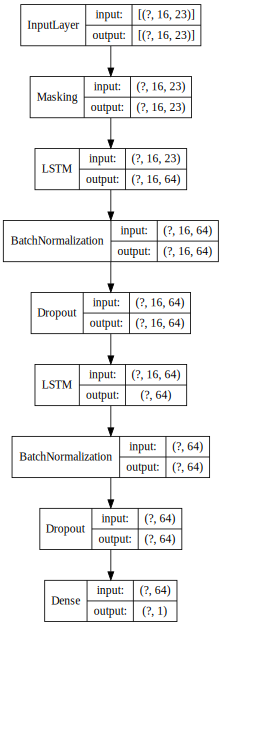

In [4]:
from IPython.display import Image, SVG
from tensorflow.keras.utils import model_to_dot

SVG(model_to_dot(model,
                 show_shapes=True, 
                 show_layer_names=False,
                 rankdir='TB',
                 expand_nested=False,
                 subgraph=False,
                 #show_layer_activations = True,
                 dpi=60).create(prog='dot', format='svg'))


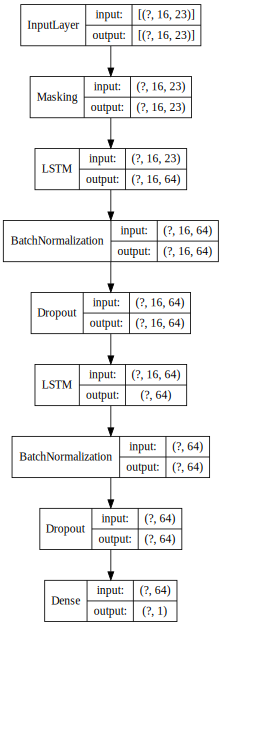

In [5]:
from IPython.display import Image, SVG
from tensorflow.keras.utils import model_to_dot

SVG(model_to_dot(model,
                 show_shapes=True, 
                 show_layer_names=False,
                 rankdir='TB',
                 expand_nested=True,
                 subgraph=False,
                 #show_layer_activations = True,
                 dpi=60).create(prog='dot', format='svg'))


Train on 704876 samples, validate on 176220 samples
Epoch 1/15
704876/704876 [==============================] - 216s 307us/sample - loss: 0.6304 - binary_accuracy: 0.6208 - val_loss: 0.6124 - val_binary_accuracy: 0.6225
Epoch 2/15
704876/704876 [==============================] - 184s 261us/sample - loss: 0.6123 - binary_accuracy: 0.6343 - val_loss: 0.6104 - val_binary_accuracy: 0.6508
Epoch 3/15
704876/704876 [==============================] - 186s 264us/sample - loss: 0.6076 - binary_accuracy: 0.6411 - val_loss: 0.6096 - val_binary_accuracy: 0.6022
Epoch 4/15
704876/704876 [==============================] - 186s 264us/sample - loss: 0.6049 - binary_accuracy: 0.6459 - val_loss: 0.6065 - val_binary_accuracy: 0.6457
Epoch 5/15
704876/704876 [==============================] - 162s 230us/sample - loss: 0.6032 - binary_accuracy: 0.6503 - val_loss: 0.6050 - val_binary_accuracy: 0.6393
Epoch 6/15
704876/704876 [==============================] - 148s 210us/sample - loss: 0.6019 - binary_accura

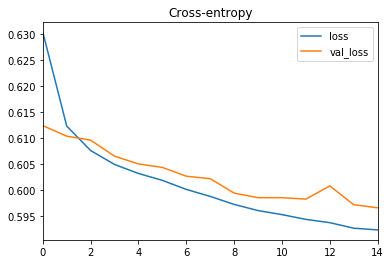

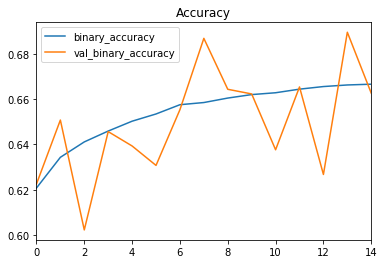

In [8]:
# Train the model, on the full data set

early_stopping = keras.callbacks.EarlyStopping(
    patience=25,
    min_delta=0.001,
    restore_best_weights=True,
)

class_weights = compute_class_weight('balanced', np.unique(y_train), y_train)

class_weight = {0: class_weights[0], 
               1: class_weights[1]}        # Done by compute_class_weight('balanced', np.unique(y_train), y_train) in cell above

  
history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=512,  #264,
    epochs=15,
    callbacks=[early_stopping],
    #verbose = 0   #Hide output of epochs
    class_weight = class_weight
)

history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot(title="Cross-entropy")
history_df.loc[:, ['binary_accuracy', 'val_binary_accuracy']].plot(title="Accuracy")
history_df = pd.DataFrame(history.history)

print(("Best Validation Loss: {:0.4f}" +\
      "\nBest Validation Accuracy: {:0.4f}")\
      .format(history_df['val_loss'].min(), 
              history_df['val_binary_accuracy'].max()))

In [8]:
# model.save('trained_rnn_model_run10.h5')

from tensorflow.keras.models import load_model
model = load_model('trained_rnn_model_run10.h5')

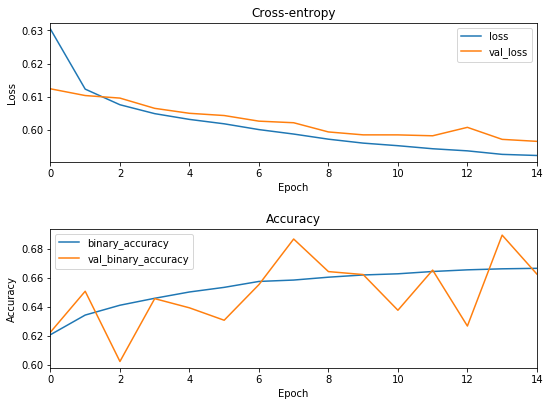

Best Validation Loss: 0.5966
Best Validation Accuracy: 0.6896


In [10]:
history_df = pd.DataFrame(history.history)
fig, axes = plt.subplots(nrows=2, figsize=(8, 6))
history_df.loc[:, ['loss', 'val_loss']].plot(ax=axes[0], title="Cross-entropy")
history_df.loc[:, ['binary_accuracy', 'val_binary_accuracy']].plot(ax=axes[1], title="Accuracy")

# Set x-axis label
axes[-1].set_xlabel("Epoch")
axes[0].set_ylabel("Loss")
axes[0].set_xlabel('Epoch')
axes[-1].set_ylabel("Accuracy")

# Set layout and padding
fig.tight_layout(pad=2.0)
plt.show()

print(("Best Validation Loss: {:0.4f}" +\
      "\nBest Validation Accuracy: {:0.4f}")\
      .format(history_df['val_loss'].min(), 
              history_df['val_binary_accuracy'].max()))

In [11]:
history_df = pd.DataFrame(history.history)


# # Save the DataFrame to an HDF5 file
with h5py.File('rnn_run10_training_data.h5', 'w') as hf:
    hf.create_dataset('df', data=history_df)

# with h5py.File('rnn_run1_training_data.h5', 'r') as hf:
#     history_df = pd.DataFrame(hf['df'][:])

True


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Validation loss: 0.5955764852090738
Validation accuracy: 0.666547


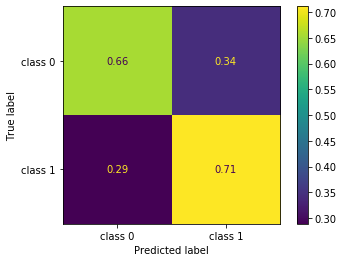

Total signal processes; 1.0
Total background processes; 1.0
294976
There is 142135 signal in the set
The model predicted 152841 more ones than in reality
409900
There is 562741 background in the set
The model predicted -152841 more ones than in reality


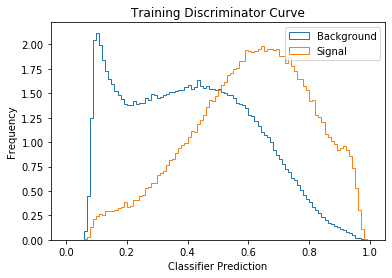

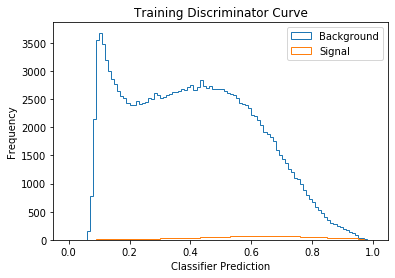

In [9]:
# evaluate the model on the training data, confusion matrix and discriminator curve

# Found model.evaluate took 383s
# Found model.predict took 
# Should have used timit really

gpu_available = tf.test.is_gpu_available()
print(gpu_available)   # check still on the gpu

val_loss, val_acc = model.evaluate(X_train, y_train)    

print("Validation loss:", val_loss)
print("Validation accuracy:", val_acc)

y_pred = model.predict(X_train, verbose = 20)
y_pred_round = np.round(y_pred)
#print(y_pred)

# compute the confusion matrix

cm = confusion_matrix(y_train, y_pred_round, normalize = 'true')   #, normalize = 'true')  #,'true' ‘pred’, ‘all’},)
#disp = ConfusionMatrixDisplay(confusion_matrix=cm) 
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['class 0', 'class 1']) # other env

disp.plot()
plt.show()

print('Total signal processes;', cm[1,0]+cm[1,1])
print('Total background processes;', cm[0,0]+cm[0,1])

# Check if order of y_valid is the same order as y_pred
# expect to be the ssame order if accuracy is same as validation accuracy above.

# list of true outcomes
y_train_list = list(y_train)

# list of rounded predictions 
y_pred_round_list = list(y_pred_round)

data_test = {'True_Val': y_train_list, 'Predicted': list(y_pred), 'Round Prediction': y_pred_round_list}
df_test = pd.DataFrame(data_test)

# Easiest to reorder df, so all 0 (background) are first and then 1's (signal)

#Verified, works
df_test = df_test.sort_values(by='True_Val')
df_test

# Convert arrays to scalars
df_test['Round Prediction'] = df_test['Round Prediction'].apply(lambda x: x[0])
        
pred_one = df_test['Round Prediction'].value_counts()[1.0]
ones_in_set = df_test['True_Val'].value_counts()[1]

# Print the result
print(pred_one)
print('There is', ones_in_set, 'signal in the set')
print('The model predicted',pred_one-ones_in_set ,'more ones than in reality')


pred_zeros = df_test['Round Prediction'].value_counts()[0.0]
zeros_in_set = df_test['True_Val'].value_counts()[0]

# Print the result
print(pred_zeros)
print('There is', zeros_in_set, 'background in the set')   #agrees w/ confusion matrix
print('The model predicted', pred_zeros-zeros_in_set,'more ones than in reality')


#Split df into signal and bg

df_bg = df_test[df_test['True_Val'] == 0]
df_signal = df_test[df_test['True_Val'] == 1]

# Make discriminator curves, Histogram

# manipluate data so can be used for Histograms
lst_bg_predicted = []
for i in df_bg['Predicted']:
    lst_bg_predicted.append(i)

lst_of_values_bg_pred_train = [arr.item() for arr in lst_bg_predicted]

lst_signal_predicted = []
for i in df_signal['Predicted']:
    lst_signal_predicted.append(i)

lst_of_values_signal_pred_train = [arr.item() for arr in lst_signal_predicted]

binwidth = 0.01
bins=np.arange(0, 1 + binwidth, binwidth)
    

#Unweighted, normalised
plt.hist(x= lst_of_values_bg_pred_train, bins=bins, density = True, histtype = 'step', label = 'Background')
plt.hist(x= lst_of_values_signal_pred_train, bins=bins, density = True, histtype = 'step', label = 'Signal')
plt.title('Training Discriminator Curve')
plt.xlabel('Classifier Prediction')
plt.ylabel('Frequency')
plt.legend()
plt.show()

#Weighted to xs_weights x 300000, need to be toproportion of full dataset too
#normalised

plt.hist(x= lst_of_values_bg_pred_train, bins=bins,  weights = df_weights[:len(lst_of_values_bg_pred_train),1]*3e5,
         histtype = 'step', label = 'Background')
plt.hist(x= lst_of_values_signal_pred_train, bins=bins, weights = df_weights[:len(lst_of_values_signal_pred_train),3]*3e5,
         histtype = 'step', label = 'Signal')
plt.title('Training Discriminator Curve')
plt.xlabel('Classifier Prediction')
plt.ylabel('Frequency')
#plt.xlim(0.9,1)    #zoom in on 0.9 to 1 region
#plt.ylim(0,200)    # need to zoom in
plt.legend()
plt.show()


#start dropping bins for signifucance part, calc Z and plot, should get curve that peaks

True
176220/1 - 59s - loss: 0.5812 - binary_accuracy: 0.6626
Validation loss: 0.5997392238600275
Validation accuracy: 0.6626433
176220/1 - 59s


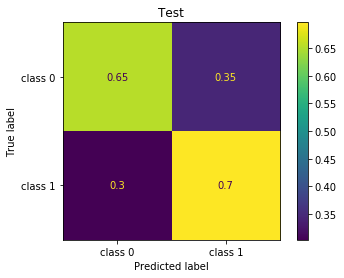

Total signal processes; 1.0
Total background processes; 1.0


In [10]:
# evaluate the model on the validation data

gpu_available = tf.test.is_gpu_available()
print(gpu_available)   # check still on the gpu

val_loss, val_acc = model.evaluate(X_valid, y_valid, verbose = 2)   
print("Validation loss:", val_loss)
print("Validation accuracy:", val_acc)

y_pred = model.predict(X_valid, verbose = 2)
y_pred_round = np.round(y_pred)

# compute the confusion matrix
cm = confusion_matrix(y_valid, y_pred_round, normalize = 'true')    #,'true' ‘pred’, ‘all’},)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['class 0', 'class 1']) # other env
#disp = ConfusionMatrixDisplay(confusion_matrix=cm)   
disp.plot()
plt.title('Test')
plt.show()

print('Total signal processes;', cm[1,0]+cm[1,1])
print('Total background processes;', cm[0,0]+cm[0,1])

In [11]:
# Check if order of y_valid is the same order as y_pred
# expect to be the ssame order if accuracy is same as validation accuracy above.

# list of true outcomes
y_valid_list = list(y_valid)

# list of rounded predictions 
y_pred_round_list = list(y_pred_round)

# list of whether these are same    
z=[]
for i in range(len(y_valid_list)):
    if y_valid_list[i]==y_pred_round_list[i]:
        z.append(1)
    else:
        z.append(0)
        
print(sum(z)/len(z))

# Set a tolerance
tol = 0.0001
print(val_acc - tol < sum(z)/len(z) < val_acc + tol)

# If true, suggests are in same order 

0.6626432868005901
True


In [12]:
print(min(y_pred))
max(y_pred)

[0.06103063]


array([0.9854244], dtype=float32)

In [13]:
data = {'True_Val': y_valid_list, 'Predicted': list(y_pred), 'Round Prediction': y_pred_round_list}
df = pd.DataFrame(data)

# Easiest to reorder df, so all 0 (background) are first and then 1's (signal)

#Verified, works
df = df.sort_values(by='True_Val')
df

# Convert arrays to scalars
df['Round Prediction'] = df['Round Prediction'].apply(lambda x: x[0])

df

,True_Val,Predicted,Round Prediction
0,0,[0.091521055],0.0
110822,0,[0.68113375],1.0
110823,0,[0.378891],0.0
110824,0,[0.2923249],0.0
110825,0,[0.61627203],1.0
...,...,...,...
100371,1,[0.09557703],0.0
60542,1,[0.9059643],1.0
60543,1,[0.7807689],1.0
60536,1,[0.7977339],1.0


In [14]:
# Check that they maintained order in the df:

lst=[]
for i in range(len(df)):
    if df['True_Val'][i] == df['Round Prediction'][i]:
        lst.append(1)
    else:
        (lst.append(0))
print(sum(lst)/len(lst))

# Set a tolerance
tol = 0.0001
print(val_acc - tol < sum(lst)/len(lst) < val_acc + tol)

# If true, suggests are in same order 

0.6626432868005901
True


In [15]:
pred_one = df['Round Prediction'].value_counts()[1.0]
ones_in_set = df['True_Val'].value_counts()[1]

# Print the result
print(pred_one)
print('There is', ones_in_set, 'signal in the set')
print('The model predicted',pred_one-ones_in_set ,'more ones than in reality')


pred_zeros = df['Round Prediction'].value_counts()[0.0]
zeros_in_set = df['True_Val'].value_counts()[0]

# Print the result
print(pred_zeros)
print('There is', zeros_in_set, 'background in the set')   #agrees w/ confusion matrix
print('The model predicted', pred_zeros-zeros_in_set,'more ones than in reality')


73488
There is 35723 signal in the set
The model predicted 37765 more ones than in reality
102732
There is 140497 background in the set
The model predicted -37765 more ones than in reality


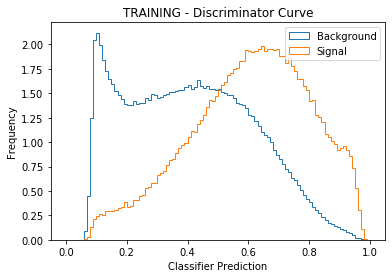

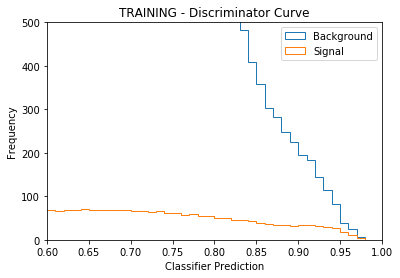

In [16]:
# Training Discriminator curves

#Unweighted, normalised
plt.hist(x= lst_of_values_bg_pred_train, bins=bins, density = True, histtype = 'step', label = 'Background')
plt.hist(x= lst_of_values_signal_pred_train, bins=bins, density = True, histtype = 'step', label = 'Signal')
plt.title('TRAINING - Discriminator Curve')
plt.xlabel('Classifier Prediction')
plt.ylabel('Frequency')
plt.legend()
plt.show()

#Weighted to xs_weights x 300000, need to be toproportion of full dataset too
#normalised


plt.hist(x= lst_of_values_bg_pred_train, bins=bins,  weights = df_weights[:len(lst_of_values_bg_pred_train),1]*3e5,
         histtype = 'step', label = 'Background')
plt.hist(x= lst_of_values_signal_pred_train, bins=bins, weights = df_weights[:len(lst_of_values_signal_pred_train),3]*3e5,
         histtype = 'step', label = 'Signal')
plt.title('TRAINING - Discriminator Curve')
plt.xlabel('Classifier Prediction')
plt.ylabel('Frequency')
plt.xlim(0.6,1)    #zoom in on 0.9 to 1 region
plt.ylim(0,500)    # need to zoom in
plt.legend()
plt.show()


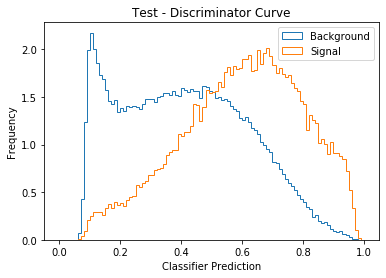

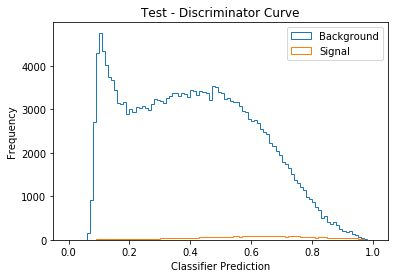

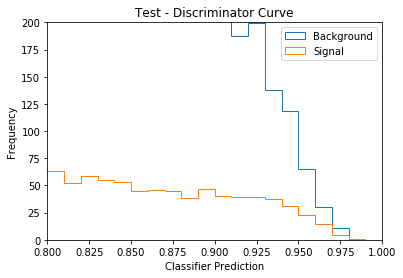

In [17]:
#Split df into signal and bg

df_bg = df[df['True_Val'] == 0]
df_signal = df[df['True_Val'] == 1]

# Make Validation discriminator curves, Histogram

# manipluate data so can be used for Histograms
lst_bg_predicted = []
for i in df_bg['Predicted']:
    lst_bg_predicted.append(i)

lst_of_values_bg_pred = [arr.item() for arr in lst_bg_predicted]

lst_signal_predicted = []
for i in df_signal['Predicted']:
    lst_signal_predicted.append(i)

lst_of_values_signal_pred = [arr.item() for arr in lst_signal_predicted]

binwidth = 0.01
bins=np.arange(0, 1 + binwidth, binwidth)

#Unweighted, normalised
plt.hist(x= lst_of_values_bg_pred, bins=bins, density = True, histtype = 'step', label = 'Background')
plt.hist(x= lst_of_values_signal_pred, bins=bins, density = True, histtype = 'step', label = 'Signal')
plt.title('Test - Discriminator Curve')
plt.xlabel('Classifier Prediction')
plt.ylabel('Frequency')
plt.legend()
plt.show()

#Weighted to xs_weights x 300000, need to be toproportion of full dataset too
#normalised
plt.hist(x= lst_of_values_bg_pred, bins=bins,  weights = df_weights[:len(lst_of_values_bg_pred),1]*3e5*1/0.2,
         histtype = 'step', label = 'Background')
plt.hist(x= lst_of_values_signal_pred, bins=bins, weights = df_weights[:len(lst_of_values_signal_pred),3]*3e5*1/0.2,
         histtype = 'step', label = 'Signal')
plt.title('Test - Discriminator Curve')
plt.xlabel('Classifier Prediction')
plt.ylabel('Frequency')
#plt.xlim(0.9,1)    #zoom in on 0.9 to 1 region
#plt.ylim(0,200)    # need to zoom in
plt.legend()
plt.show()
    
plt.hist(x= lst_of_values_bg_pred, bins=bins,  weights = df_weights[:len(lst_of_values_bg_pred),1]*3e5*1/0.2,
         histtype = 'step', label = 'Background')
plt.hist(x= lst_of_values_signal_pred, bins=bins, weights = df_weights[:len(lst_of_values_signal_pred),3]*3e5*1/0.2,
         histtype = 'step', label = 'Signal')
plt.title('Test - Discriminator Curve')
plt.xlabel('Classifier Prediction')
plt.ylabel('Frequency')
plt.xlim(0.8,1)    #zoom in on 0.9 to 1 region
plt.ylim(0,200)    # need to zoom in
plt.legend()
plt.show()


#start dropping bins for signifucance part, calc Z and plot, should get curve that peaks

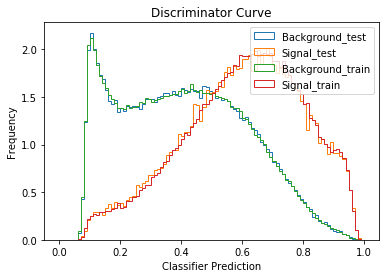

In [18]:
# Test and Training overlayed

#Unweighted, normalised
plt.hist(x= lst_of_values_bg_pred, bins=bins, density = True, histtype = 'step', label = 'Background_test')
plt.hist(x= lst_of_values_signal_pred, bins=bins, density = True, histtype = 'step', label = 'Signal_test')
plt.title('Test - Discriminator Curve')
plt.xlabel('Classifier Prediction')
plt.ylabel('Frequency')
plt.legend()


#Unweighted, normalised
plt.hist(x= lst_of_values_bg_pred_train, bins=bins, density = True, histtype = 'step', label = 'Background_train')
plt.hist(x= lst_of_values_signal_pred_train, bins=bins, density = True, histtype = 'step', label = 'Signal_train')
plt.title('Discriminator Curve')
plt.xlabel('Classifier Prediction')
plt.ylabel('Frequency')
plt.legend()
plt.show()

num_bg_events =  217042.24996948242
num_signal_events =  4417.765137314796


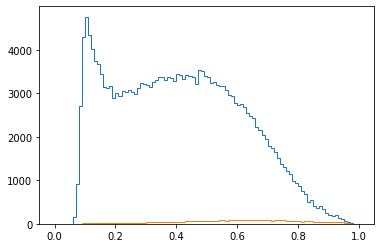

In [18]:
#Calculate number of events

n_bg, bins_bg, patches_bg = plt.hist(x= lst_of_values_bg_pred, bins=bins,  weights = df_weights[:len(lst_of_values_bg_pred),1]*3e5*1/0.2,
         histtype = 'step', label = 'Background')
n_signal, bins_signal, patches_signal = plt.hist(x= lst_of_values_signal_pred, bins=bins, weights = df_weights[:len(lst_of_values_signal_pred),3]*3e5*1/0.2,
         histtype = 'step', label = 'Signal')

# calculate the number of events
num_bg_events = np.sum(n_bg)
num_signal_events = np.sum(n_signal)

print('num_bg_events = ', num_bg_events)
print('num_signal_events = ', num_signal_events)

In [23]:
df['True_Val'] = df['True_Val'].astype(float)
df['Predicted'] = df['Predicted'].astype(float)
df['Round Prediction'] = df['Round Prediction'].astype(float)


# Save the DataFrame to an HDF5 file
with h5py.File('rnn_run10_ROC_data.h5', 'w') as hf:
    hf.create_dataset('df', data=df)
    
# with h5py.File('rnn_run1_ROC_data.h5', 'r') as hf:
#     df = pd.DataFrame(hf['df'][:])


In [24]:
# #plot ROC curves

# y_true = df['True_Val']
# y_score = df['Predicted']

# # calculate the false positive rate and true positive rate
# fpr, tpr, thresholds = roc_curve(y_true, y_score)

# # calculate the area under the ROC curve
# roc_auc = auc(fpr, tpr)

# # plot the ROC curve
# plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
# plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.05])
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('Receiver Operating Characteristic')
# plt.legend(loc="lower right")
# plt.show()

# print(roc_auc)  

# print(len(thresholds))



In [25]:
# data_roc = {'thresholds': thresholds, 'tpr': tpr, 'fpr': fpr, 'tpr/sqrt(fpr)':tpr/np.sqrt(fpr)}
# df_roc = pd.DataFrame(data_roc)
# #df_roc
# df_roc.head(20)
# plt.plot(df_roc['thresholds'][3:], df_roc['tpr/sqrt(fpr)'][3:])
# plt.show()
# max(df_roc['tpr/sqrt(fpr)'][3:])

In [26]:
# # Plot precision recall curve
# from sklearn.metrics import average_precision_score

# y_true = df['True_Val']
# y_score = df['Predicted']

# # calculate the precision-recall curve
# precision, recall, _ = precision_recall_curve(y_true, y_score)

# # plot the precision-recall curve
# plt.step(recall, precision, color='b', alpha=0.2, where='post')
# plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
# plt.xlabel('Recall')
# plt.ylabel('Precision')
# plt.ylim([0.0, 1.05])
# plt.xlim([0.0, 1.0])
# plt.title('Precision-Recall Curve')
# plt.show()

# AUC = average_precision_score(y_true, y_score)   
# print(AUC)

In [27]:
# df['True_Val']
# x = df['Predicted']
# print(x)

# Significance

$$ Z = \frac{s}{\sqrt(B+\sigma_s^{2})}  $$

s = number of signal

B = number of background

$\sigma_s$ = statistical uncertainty (~10% of B)

217042.24996948242
4417.765137314796


/software/deep-learning/envs/ml-microscope/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in double_scalars
  # This is added back by InteractiveShellApp.init_path()
/software/deep-learning/envs/ml-microscope/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in double_scalars
  # This is added back by InteractiveShellApp.init_path()


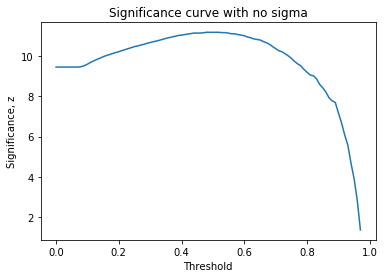

0.48
48
11.182060713746376

If cut at a threshold of 0.48 have
3219.7880859375 singal events
81844.40625 background events


/software/deep-learning/envs/ml-microscope/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in less


In [19]:
num_bg_events = np.sum(n_bg)
num_signal_events = np.sum(n_signal)

print(num_bg_events)
print(num_signal_events)

z_0 = np.empty(len(bins_bg))
for i in range(len(bins_bg)):
    b = np.sum(n_bg[i:])
    s = np.sum(n_signal[i:])
    z_i = np.sqrt(2*((s+b)*np.log(1+(s/b))-s))  
    z_0[i] = z_i

x = np.linspace(0,1,len(z_0))
plt.plot(bins_bg,z_0[:])
plt.xlabel('Threshold')
plt.ylabel('Significance, z')
plt.title('Significance curve with no sigma')
plt.show()


mask_0 = z_0 < 1e10     #just so doesnt include infs
index_of_max_0 = np.argmax(z_0[mask_0])
max_value_0 = np.amax(z_0[mask_0])


#index_of_max = np.nanargmax(z[:])
#max_value = np.nanmax(z[:])     # 1 point before last, should probs generalise so that can deal w inf etc 
max_bin_0 = bins_bg[index_of_max_0]
print(max_bin_0)
print(index_of_max_0)
print(max_value_0)

# significance = sigmna, 6.5 signma, 5 sigma

num_bg_threshold_0 = np.sum(n_bg[index_of_max_0:])
num_signal_threshold_0 = np.sum(n_signal[index_of_max_0:])

print()
print('If cut at a threshold of', index_of_max_0/100, 'have')
print(num_signal_threshold_0, 'singal events')
print(num_bg_threshold_0, 'background events')

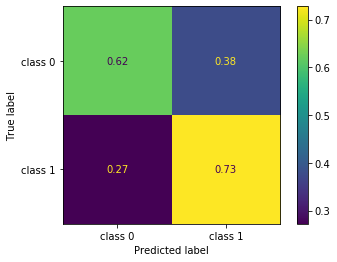

Total signal processes; 1.0
Total background processes; 1.0


In [20]:
# Confusion matricies with new threshold at max significance

# calculates prediction values
#y_pred = model.predict(X_valid) 

significance_threshold_0 = max_bin_0
y_pred_threshold_0 = np.where(y_pred >= significance_threshold_0, 1, 0)

# compute the confusion matrix
cm = confusion_matrix(y_valid, y_pred_threshold_0, normalize = 'true')    #,'true' ‘pred’, ‘all’},)
#disp = ConfusionMatrixDisplay(confusion_matrix=cm)   
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['class 0', 'class 1']) # other env
disp.plot()
plt.show()

print('Total signal processes;', cm[1,0]+cm[1,1])
print('Total background processes;', cm[0,0]+cm[0,1])

217042.24996948242
4417.765137314796


/software/deep-learning/envs/ml-microscope/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in double_scalars
  del sys.path[0]
/software/deep-learning/envs/ml-microscope/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in double_scalars
  


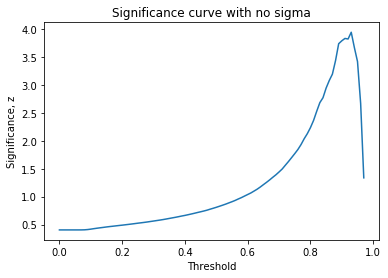

0.93
93
3.9451978543568695

If cut at a threshold of 0.93 have
111.20654296875 singal events
363.046875 background events


/software/deep-learning/envs/ml-microscope/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in less


In [21]:
num_bg_events = np.sum(n_bg)
num_signal_events = np.sum(n_signal)

print(num_bg_events)
print(num_signal_events)

z_5 = np.empty(len(bins_bg))
for i in range(len(bins_bg)):
    b = np.sum(n_bg[i:])
    s = np.sum(n_signal[i:])

    sigma = 0.05*b  
    part1 = (s+b)*np.log(((s+b)*(b+sigma**2))/(b**2+((s+b)*sigma**2)))
    part2 = (b**2/sigma**2)*np.log(1+((sigma**2*s)/(b*(b+sigma**2))))
    
    z_5[i] = (2*(part1-part2))**(1/2)

x = np.linspace(0,1,len(z_5))
plt.plot(bins_bg,z_5[:])
plt.xlabel('Threshold')
plt.ylabel('Significance, z')
plt.title('Significance curve with no sigma')
plt.show()


mask_5 = z_5 < 1e10     #just so doesnt include infs
index_of_max_5 = np.argmax(z_5[mask_5])
max_value_5 = np.amax(z_5[mask_5])


#index_of_max = np.nanargmax(z[:])
#max_value = np.nanmax(z[:])     # 1 point before last, should probs generalise so that can deal w inf etc 
max_bin_5 = bins_bg[index_of_max_5]
print(max_bin_5)
print(index_of_max_5)
print(max_value_5)

# significance = sigmna, 6.5 signma, 5 sigma

num_bg_threshold_5 = np.sum(n_bg[index_of_max_5:])
num_signal_threshold_5 = np.sum(n_signal[index_of_max_5:])

print()
print('If cut at a threshold of', index_of_max_5/100, 'have')
print(num_signal_threshold_5, 'singal events')
print(num_bg_threshold_5, 'background events')

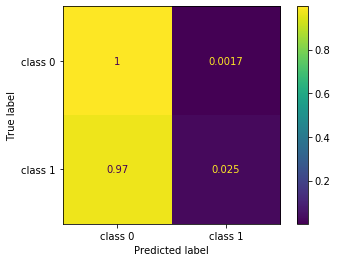

Total signal processes; 1.0
Total background processes; 1.0


In [22]:
# Confusion matricies with new threshold at max significance

# calculates prediction values
#y_pred = model.predict(X_valid) 

significance_threshold_5 = max_bin_5
y_pred_threshold_5 = np.where(y_pred >= significance_threshold_5, 1, 0)

# compute the confusion matrix
cm = confusion_matrix(y_valid, y_pred_threshold_5, normalize = 'true')    #,'true' ‘pred’, ‘all’},)
#disp = ConfusionMatrixDisplay(confusion_matrix=cm)   
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['class 0', 'class 1']) # other env
disp.plot()
plt.show()

print('Total signal processes;', cm[1,0]+cm[1,1])
print('Total background processes;', cm[0,0]+cm[0,1])

217042.24996948242
4417.765137314796


/software/deep-learning/envs/ml-microscope/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in double_scalars
  del sys.path[0]
/software/deep-learning/envs/ml-microscope/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in double_scalars
  


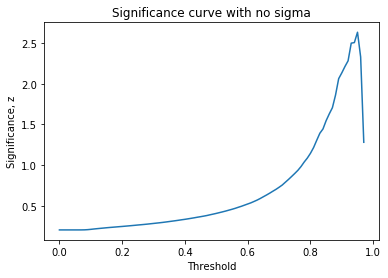

0.9500000000000001
95
2.6327265440211254

If cut at a threshold of 0.95 have
42.63134765625 singal events
106.21875 background events


/software/deep-learning/envs/ml-microscope/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in less


In [23]:
num_bg_events = np.sum(n_bg)
num_signal_events = np.sum(n_signal)

print(num_bg_events)
print(num_signal_events)

z_10 = np.empty(len(bins_bg))
for i in range(len(bins_bg)):
    b = np.sum(n_bg[i:])
    s = np.sum(n_signal[i:])

    sigma = 0.1*b  
    part1 = (s+b)*np.log(((s+b)*(b+sigma**2))/(b**2+((s+b)*sigma**2)))
    part2 = (b**2/sigma**2)*np.log(1+((sigma**2*s)/(b*(b+sigma**2))))
    
    z_10[i] = (2*(part1-part2))**(1/2)

x = np.linspace(0,1,len(z_10))
plt.plot(bins_bg,z_10[:])
plt.xlabel('Threshold')
plt.ylabel('Significance, z')
plt.title('Significance curve with no sigma')
plt.show()


mask_10 = z_10 < 1e10     #just so doesnt include infs
index_of_max_10 = np.argmax(z_10[mask_10])
max_value_10 = np.amax(z_10[mask_10])


#index_of_max = np.nanargmax(z[:])
#max_value = np.nanmax(z[:])     # 1 point before last, should probs generalise so that can deal w inf etc 
max_bin_10 = bins_bg[index_of_max_10]
print(max_bin_10)
print(index_of_max_10)
print(max_value_10)

# significance = sigmna, 6.5 signma, 5 sigma

num_bg_threshold_10 = np.sum(n_bg[index_of_max_10:])
num_signal_threshold_10 = np.sum(n_signal[index_of_max_10:])

print()
print('If cut at a threshold of', index_of_max_10/100, 'have')
print(num_signal_threshold_10, 'singal events')
print(num_bg_threshold_10, 'background events')

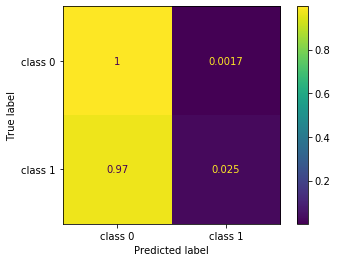

Total signal processes; 1.0
Total background processes; 1.0


In [24]:
# Confusion matricies with new threshold at max significance

# calculates prediction values
#y_pred = model.predict(X_valid) 

significance_threshold_10 = max_bin_10
y_pred_threshold_10 = np.where(y_pred >= significance_threshold_10, 1, 0)

# compute the confusion matrix
cm = confusion_matrix(y_valid, y_pred_threshold_5, normalize = 'true')    #,'true' ‘pred’, ‘all’},)
#disp = ConfusionMatrixDisplay(confusion_matrix=cm)   
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['class 0', 'class 1']) # other env
disp.plot()
plt.show()

print('Total signal processes;', cm[1,0]+cm[1,1])
print('Total background processes;', cm[0,0]+cm[0,1])

In [25]:
raw_sig_curve_data = {'syst_uncertainty (0%)': z_0, 
                      'syst_uncertainty (5%)': z_5, 
                      'syst_uncertainty (10%)': z_10, 
                     }
raw_sig_df = pd.DataFrame(raw_sig_curve_data)


# Save the DataFrame to an HDF5 file
with h5py.File('raw_rnn_sig_data_run10.h5', 'w') as hf:
    hf.create_dataset('df', data=raw_sig_df)

In [34]:
significances = np.array((max_value_0, max_value_5, max_value_10))
syst_uncertainty = np.array((0, 0.05, 0.1))
discriminators = np.array((index_of_max_0/100, index_of_max_5/100, index_of_max_10/100))
num_bg_threshold = np.array((num_bg_threshold_0, num_bg_threshold_5, num_bg_threshold_10))
num_signal_threshold = np.array((num_signal_threshold_0,num_signal_threshold_5,num_signal_threshold_10))

In [35]:
sig_curve_data = {'syst_uncertainty (%)': syst_uncertainty, 'Significances': significances, 'Threshold': discriminators, 'no_bg': num_bg_threshold, 'no_signal':num_signal_threshold}
sig_df = pd.DataFrame(sig_curve_data)


# Save the DataFrame to an HDF5 file
with h5py.File('rnn_sig_data_run10.h5', 'w') as hf:
    hf.create_dataset('df', data=sig_df)
    
# with h5py.File('rnn_ROC_data.h5', 'r') as hf:
#     df = pd.DataFrame(hf['df'][:])

# can make confusion matricies with things I have saved

In [36]:
sig_df

,syst_uncertainty (%),Significances,Threshold,no_bg,no_signal
0,0.00,11.182061,0.48,81844.406250,3219.788086
1,0.05,3.945198,0.93,363.046875,111.206543
2,0.10,2.632727,0.95,106.218750,42.631348


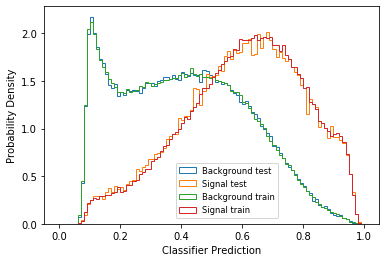

In [21]:
# Test and Training overlayed

#Unweighted, normalised
plt.hist(x= lst_of_values_bg_pred, bins=bins, density = True, histtype = 'step', label = 'Background test')
plt.hist(x= lst_of_values_signal_pred, bins=bins, density = True, histtype = 'step', label = 'Signal test')

#Unweighted, normalised
plt.hist(x= lst_of_values_bg_pred_train, bins=bins, density = True, histtype = 'step', label = 'Background train')
plt.hist(x= lst_of_values_signal_pred_train, bins=bins, density = True, histtype = 'step', label = 'Signal train')
#plt.title('Discriminator Curve')
plt.xlabel('Classifier Prediction')
plt.ylabel('Probability Density')
plt.legend(fontsize='small')
#plt.xlim(0,1.2)
#plt.ylim(0,2.5)
place = 'upper left'
#offset = (0.15,0.68)
offset = (0.38,0.3)

plt.legend(loc = place, bbox_to_anchor = offset, fontsize='small' )

plt.savefig('RNN_DISC_CURVE.png', dpi=300, bbox_inches='tight')

In [ ]:
plt.savefig('RNN_DISC_CURVE.png', dpi=300, bbox_inches='tight')

# SAVE THE CORRECT DATA

In [37]:
y_pred_valid = model.predict(X_valid, verbose = 2)
y_pred_train = model.predict(X_train, verbose = 2)

with h5py.File('rnn_run10_predictions.h5', 'w') as f:
    f.create_dataset('val_preds', data=y_pred_valid)
    f.create_dataset('train_preds', data=y_pred_train)

176220/1 - 140s
704876/1 - 532s


In [38]:
# # Make not an object, so can hdf save
# # run last anyways

# df['True_Val'] = df['True_Val'].astype(float)
# df['Predicted'] = df['Predicted'].astype(float)
# df['Round Prediction'] = df['Round Prediction'].astype(float)


In [39]:

# with h5py.File('data_valid_16pad_128_50epoch_4Layers_SEED10.h5', 'w') as f:
#     f.create_dataset('True_Val', data=df['True_Val'])
#     f.create_dataset('Predicted', data=df['Predicted'])
#     f.create_dataset('Round_Prediction', data=df['Round Prediction'])

    
# #with h5py.File('data_train_16pad_RNN3_SEED10.h5', 'r') as f:
# #   true_val = f['True_Val'][:]
# #   predicted = f['Predicted'][:]
# #   round_pred = f['Round_Prediction'][:]
    


# #my_dict = {'True_Val': true_val.flatten(), 'Predicted': predicted.flatten(), 'Round Prediction': round_pred.flatten()}
# #df = pd.DataFrame(my_dict)

In [40]:
# df_test['True_Val'] = df_test['True_Val'].astype(float)
# df_test['Predicted'] = df_test['Predicted'].astype(float)
# df_test['Round Prediction'] = df_test['Round Prediction'].astype(float)

# with h5py.File('data_train_16pad_128_50epoch_4Layers_SEED10.h5', 'w') as f:
#     f.create_dataset('True_Val', data=df_test['True_Val'])
#     f.create_dataset('Predicted', data=df_test['Predicted'])
#     f.create_dataset('Round_Prediction', data=df_test['Round Prediction'])